## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import shap

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
demanda_meteo = pd.read_csv('demanda_meteo.csv', header = 0)
demanda_meteo['Datetime'] = pd.to_datetime(demanda_meteo['Datetime'])
demanda_meteo.head()

,Datetime,Demanda Real,Demanda Prevista,Demanda Programada,Demanda D+1,Precio,temperature_2m_1,direct_normal_irradiance_instant_1,wind_speed_100m_1,temperature_2m_2,...,wind_speed_100m_50,temperature_2m_51,direct_normal_irradiance_instant_51,wind_speed_100m_51,temperature_2m_52,direct_normal_irradiance_instant_52,wind_speed_100m_52,temperature_2m_0,direct_normal_irradiance_instant_0,wind_speed_100m_0
0,2014-01-01 00:00:00,24301.66667,23878.33333,24099.0,0.0,37.21,7.4985,0.0,16.099690,7.874,...,30.758411,11.714001,0.0,17.339897,10.032000,0.0,11.659777,5.791485,0.0,18.565381
1,2014-01-01 01:00:00,23365.33333,23322.00000,22269.0,0.0,30.57,7.0485,0.0,17.388409,7.724,...,30.312773,11.614000,0.0,18.000000,9.731999,0.0,10.661107,5.709594,0.0,18.443398
2,2014-01-01 02:00:00,21672.50000,21711.16667,21136.0,0.0,26.30,7.3985,0.0,19.319628,7.574,...,27.792374,11.564000,0.0,17.651016,9.932000,0.0,11.212135,5.620734,0.0,18.401250
3,2014-01-01 03:00:00,20192.00000,20230.33333,19911.0,0.0,26.18,7.3485,0.0,20.140705,7.424,...,25.772078,11.464001,0.0,18.430452,10.432000,0.0,12.620554,5.597380,0.0,18.198554
4,2014-01-01 04:00:00,19220.66667,19215.33333,19060.0,0.0,22.40,7.4985,0.0,21.995380,7.374,...,23.732710,11.464001,0.0,18.161278,10.582000,0.0,14.058450,5.656951,0.0,18.100382


In [6]:
ndays_base = 28
ntemps = 5
nrads = 5
normalization = True
name_file = str(ndays_base)+'Days-'+str(ntemps)+'Temps-'+str(nrads)+'Rads.csv'

In [7]:
combined_base = pd.read_csv('./Base Inputs/Variations/'+name_file,header=0)
combined_base['Datetime'] = pd.to_datetime(combined_base['Datetime'])

In [8]:
cols = combined_base.columns
if normalization:
    normalization_parameters = {i:[] for i in cols[4:]}
    for name in cols[4:]:
        aux = combined_base[name].values
        delta = max(aux)-min(aux)
        minimo = min(aux)
        normalization_parameters[name].append(delta)
        normalization_parameters[name].append(minimo)
        aux = (aux - min(aux))/(max(aux)-min(aux))
        combined_base[name] = aux
    normalization_parameters = pd.DataFrame(normalization_parameters)
    normalization_parameters = normalization_parameters.rename(index={0: 'Delta', 1: 'Minimo'})
    print (normalization_parameters)

          F         L        M        X         J         V        S  \
Delta   1.0  5.784642  7.22602  7.22602  7.244857  7.244857  7.22602   
Minimo  0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.00000   

             IPC       Demanda  Temp_Ocean  ...  Temp_Med_S  Temp_Arido  \
Delta   0.049660  19473.440477   24.296530  ...   25.021825   28.537216   
Minimo  0.980921  18153.351190  -12.109515  ...  -13.621727  -15.437454   

        Temp_Cont    Rad_Ocean    Rad_Med_N    Rad_Med_S    Rad_Arido  \
Delta   26.177648  1228.312175  1464.261728  1347.446777  1444.313131   
Minimo -13.733033  -594.248623  -779.341384  -765.815529  -835.420535   

           Rad_Cont     Viento      Precio  
Delta   1265.719331  45.945262  351.530714  
Minimo  -729.556146 -16.960417   11.779643  

[2 rows x 21 columns]


In [9]:
años_train = 8
años_validation = 1
años_test = 10 - años_train - años_validation

start_year = 2014
days_year = [365,365,366,365,365,365,366,365,365,365]
days_month = [31,28,31,30,31,30,31,31,30,31,30,31]
days_bisiesto = [31,29,31,30,31,30,31,31,30,31,30,31]

days_training = sum (days_year[:años_train])
hours_training = 24*days_training

days_validation = sum (days_year[años_train:años_train+años_validation])
hours_validation = 24*days_validation

days_testing = sum(days_year[años_train+años_validation:])
hours_testing = 24*days_testing

In [10]:
x = []
x_train = []
x_val = []
x_test = []

y = []
y_train = []
y_val = []
y_test = []

prevision = []
prevision_train = []
prevision_val = []
prevision_test = []

In [11]:
drop_columns = ['Demanda', 'IPC', 'Precio']
combined_base = combined_base.drop(columns=drop_columns)

In [12]:
for i in range (24*ndays_base, len(combined_base)):
    aux = []
    year = combined_base['Datetime'][i].year
    
    if normalization:
        real = (demanda_meteo['Demanda Real'][i] - normalization_parameters['Demanda']['Minimo'])/normalization_parameters['Demanda']['Delta']
        prevista = (demanda_meteo['Demanda D+1'][i] - normalization_parameters['Demanda']['Minimo'])/normalization_parameters['Demanda']['Delta']
    else:
        real = demanda_meteo['Demanda Real'][i]
        prevista = demanda_meteo['Demanda D+1'][i]
        
    for n in range (1,ndays_base+1):
        demanda = (demanda_meteo['Demanda Real'][i-24*n]  - normalization_parameters['Demanda']['Minimo'])/normalization_parameters['Demanda']['Delta']
        aux.append(demanda)
    
    for name in combined_base.columns[1:]:
        aux.append(combined_base[name][i])
    
    if (year- start_year < años_train):
        x_train.append(aux)
        y_train.append(real)
        prevision_train.append(prevista)
        
    elif (year- start_year - años_train < años_validation):
        x_val.append(aux)
        y_val.append(real)
        prevision_val.append(prevista)

    elif (year - start_year - años_train - años_validation < años_test):
        x_test.append(aux)
        y_test.append(real)
        prevision_test.append(prevista)
        
x = x_train + x_val + x_test
y = y_train + y_val + y_test
prevision = prevision_train + prevision_val + prevision_test

In [13]:
print (len(x), len(x_train), len(x_val), len(x_test))

86232 68712 8760 8760


In [14]:
def metricas (preds, val, normalized):
    df = {}
    if normalized:
        auxpreds = np.array(preds)*normalization_parameters['Demanda']['Delta']+normalization_parameters['Demanda']['Minimo']
        auxval = np.array(val)*normalization_parameters['Demanda']['Delta']+normalization_parameters['Demanda']['Minimo']
    else:
        auxpreds = np.array(preds)
        auxval = np.array(val)
#     all_hours = pd.date_range(start=df['Date'].min(), end=df['Date'].max() + pd.Timedelta(days=1), freq='H')[:-1]

    df['Datetime'] = demanda_meteo[(demanda_meteo['Datetime'].dt.year - start_year - años_train - años_validation < años_test) & (demanda_meteo['Datetime'].dt.year - start_year - años_train - años_validation >= 0)]['Datetime']
    df['Error'] = auxpreds-auxval
    df['Absolute Error'] = abs(df['Error'])
    df['Squared Error'] = (auxpreds-auxval)*(auxpreds-auxval)
    df['Relative Error'] = 100*abs((auxpreds-auxval)/auxval)
    overall = [np.sqrt(np.mean(df['Error']*df['Error'])), np.mean(df['Absolute Error']), np.mean(df['Relative Error']), max(df['Absolute Error'])]
    
    # Assuming your dictionary is named 'data_dict'
    # Concatenate dataframes from the dictionary into one large dataframe
#     combined_df = pd.concat([d.assign(datetime=pd.to_datetime(df['Datetime'], format='%d-%m-%Y') + pd.DateOffset(hours=hour)) 
#                              for hour, d in df.items()])
#     combined_df = pd.concat([d for d in df.items()])

#     print([[name, len(df[name])] for name in df.keys()])
    df = pd.DataFrame(df)
    # Sort the dataframe by the datetime column
    df = df.sort_values(by='Datetime')

    # Convert datetime column to the desired format (day-month-year hour)
#     combined_df['Datetime'] = combined_df['Datetime'].dt.strptime(combined_df['Datetime'], '%Y-%m-%d %H:%M:%S')

    # Optionally, reset index if needed
    df = df.reset_index(drop=True)

    # Now, combined_df contains the concatenated and sorted dataframe with the desired datetime format,
    # where the hour comes from the key of the dictionary
    
    return df,overall
#     return combined_df

## Linear Regression

In [15]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error  # we will use MSE for evaluation

lambdas = [0] + [10**i for i in range (-5,0)]
models = {}
predictions = {}
metrics = {'RMSE': [], 'MAE': [], 'MAPE': [], 'MAX': []}
relevances = {}

for l in lambdas:
        # in sklearn, they refer to lambda as alpha, the name is different in different literature
        model = Lasso(alpha=l) # we allow max number of iterations until the model converges
        model.fit(x_train + x_val, y_train + y_val)
        
        models[l] = model
        predictions[l] = model.predict(x_test)
#         print (predictions[l])
        
        df, linear_metrics = metricas (predictions[l], y_test, normalization)
        metrics['RMSE'].append(round (linear_metrics[0], 1))
        metrics['MAE'].append(round (linear_metrics[1], 1))
        metrics['MAPE'].append(round (linear_metrics[2], 2))
        metrics['MAX'].append(round (linear_metrics[3], 1))

metrics = pd.DataFrame (metrics)
metrics.index = metrics.index.map(lambda i: lambdas[i])
metrics =  metrics.T
metrics

,0.00000,0.00001,0.00010,0.00100,0.01000,0.10000
RMSE,1208.80,1208.20,1202.30,1335.90,1916.70,4716.10
MAE,821.10,820.70,817.90,952.10,1509.00,3897.30
MAPE,3.19,3.19,3.18,3.71,6.07,16.49
MAX,7435.40,7452.50,7578.00,7648.50,8239.00,12502.00


In [16]:
feature_names = [str(i) for i in range (1,ndays_base+1)] + list (combined_base.columns[1:11])+['TO', 'TN', 'TS', 'TA', 'TC', 'RO', 'RN', 'RS', 'RA', 'RC', 'Wi']
# feature_names

In [42]:
def plot_relevance(l):
    aux = {i:0 for i in range(len(x_train[0]))}
    n = len(x_train)
    means = pd.DataFrame(x_train+x_val).mean()
    std = pd.DataFrame(x_train+x_val).std()
#     relevance = [abs(aux[i]*models[l].coef_[i]) for i in range (len(aux))]
    relevance = abs(models[l].coef_*std)

    relevance[relevance == 0] = np.nan
    
    fig, (ax1, ax2) = plt.subplots (2,1)
    
    fig.set_figheight (10)
    fig.set_figwidth (15)
    
#     ylim = (0, max(relevance)+0.05)
    
#     plt.setp ((ax1,ax2), ylim=ylim)
    
#     ax1.set_title ('Lag relevance for alpha=' + str(l))
#     ax1.plot (feature_names[:ndays_base], relevance[:ndays_base], 'o-')
#     ax1.set_yscale('log')

# #     ax2.set_title ('Exogenous feature relevance for alpha=' + str(l))
#     ax2.plot (feature_names[ndays_base:], relevance[ndays_base:], 'o-')
#     ax2.set_yscale('log')
    
#     plt.show()

    y_min = np.nanmin(relevance)
    y_max = np.nanmax(relevance)
    
    ylim = (y_min, y_max+0.02)
    
    plt.setp ((ax1,ax2), ylim=ylim)
    
    ax1.set_title ('Lags relevance for alpha=' + str(l))
    for i in range(ndays_base):
        ax1.axvline(x=feature_names[i], color='lightgray', linestyle='--')  # Vertical line
    ax1.scatter (feature_names[:ndays_base],relevance[:ndays_base], s=3000*np.sqrt(relevance[:ndays_base]))
    ax1.set_yscale('log')

    ax2.set_title ('Exogenous features relevance for alpha=' + str(l))
    for i in range(ndays_base, len(feature_names)):
        ax2.axvline(x=feature_names[i], color='lightgray', linestyle='--')  # Vertical line
    ax2.scatter (feature_names[ndays_base:],  relevance[ndays_base:], s=3000*np.sqrt(relevance[ndays_base:]))
    ax2.set_yscale('log')
    
    plt.show()
    return relevance

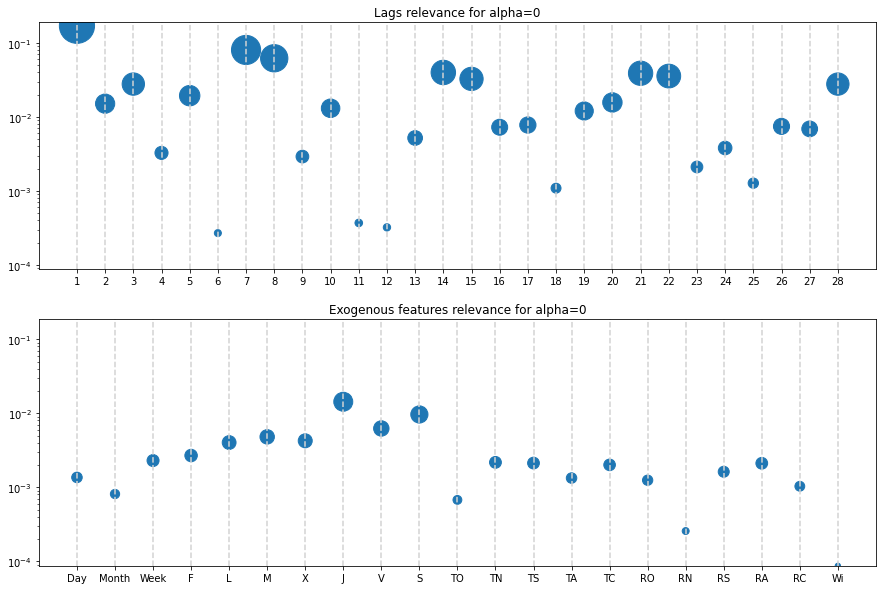

In [43]:
relevances [lambdas[0]] = plot_relevance(lambdas[0])

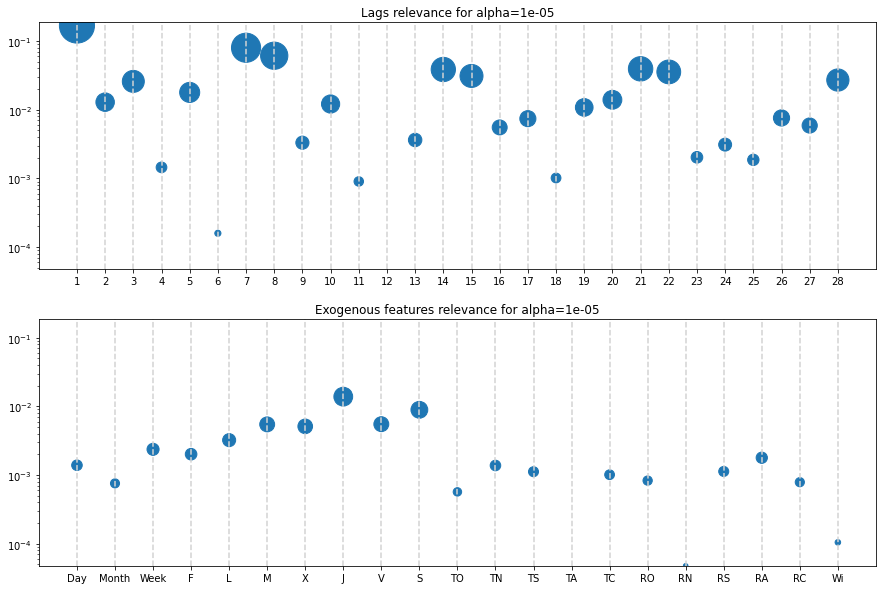

In [44]:
relevances [lambdas[1]] =plot_relevance(lambdas[1])

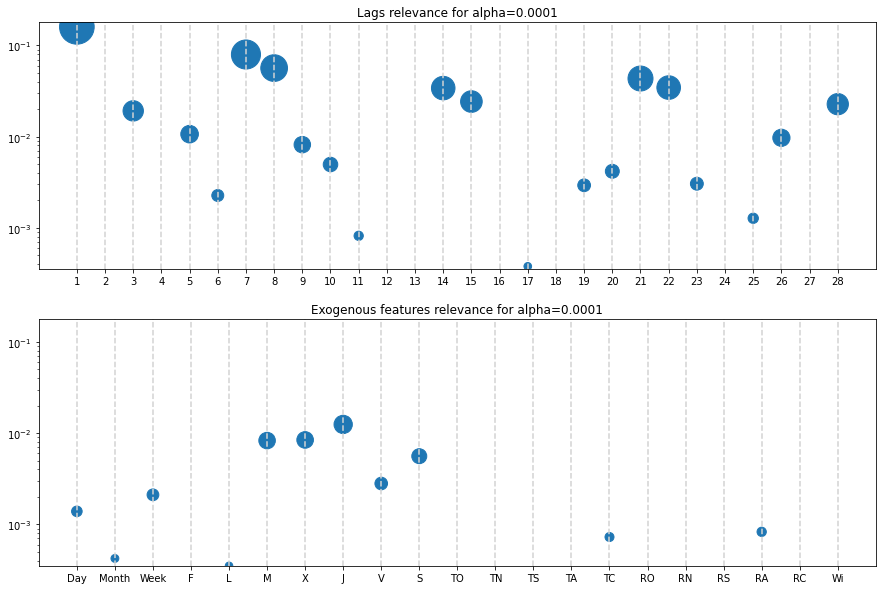

In [45]:
relevances [lambdas[2]] =plot_relevance(lambdas[2])

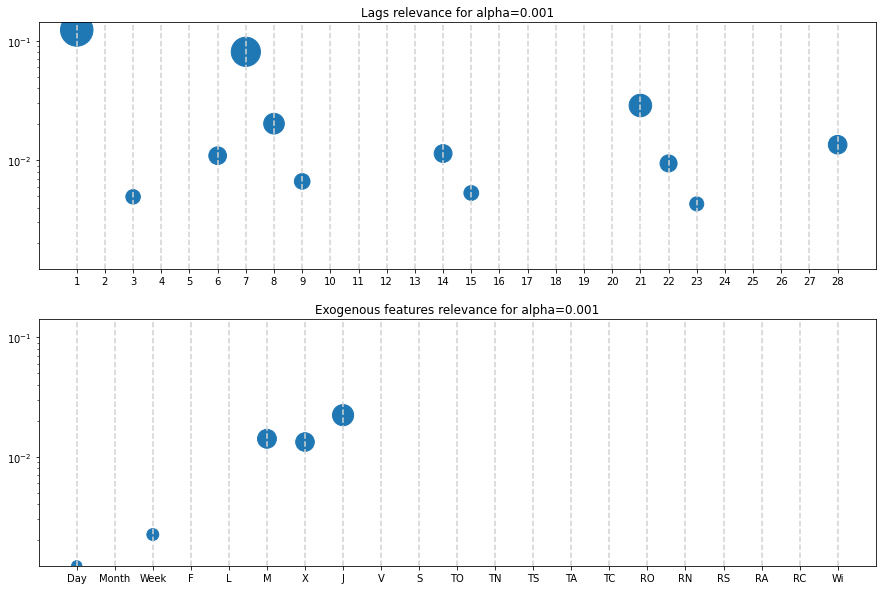

In [46]:
relevances [lambdas[3]] =plot_relevance(lambdas[3])

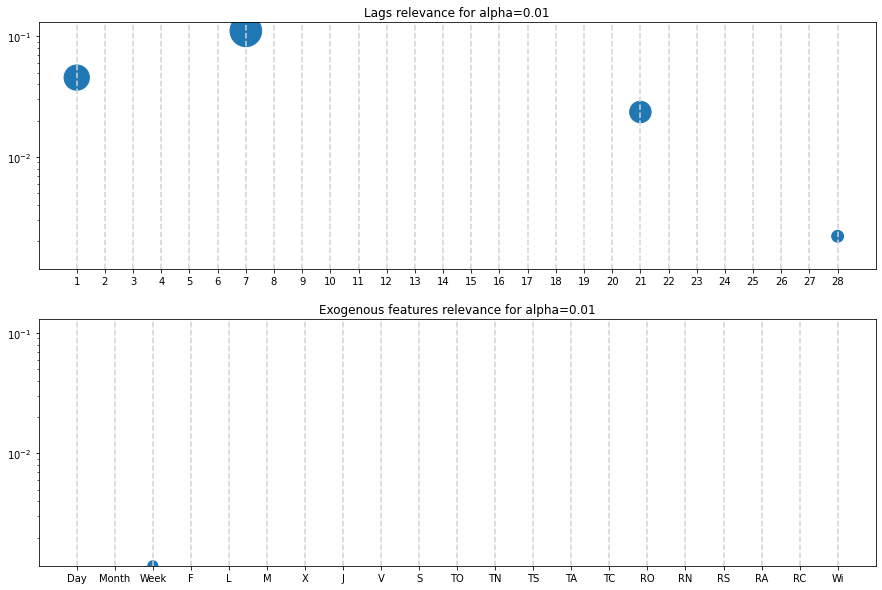

In [47]:
relevances [lambdas[4]] =plot_relevance(lambdas[4])

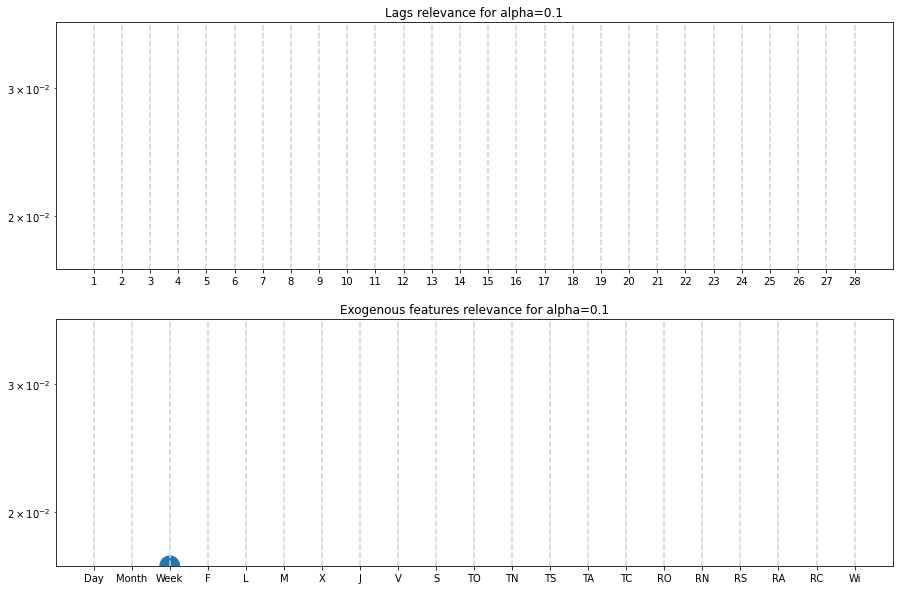

In [48]:
relevances [lambdas[5]] =plot_relevance(lambdas[5])

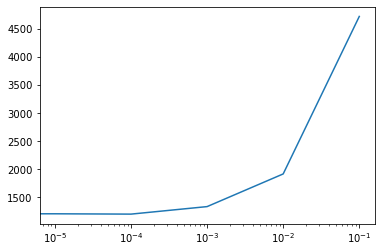

In [24]:
plt.plot(lambdas, metrics.loc['RMSE',:])
plt.xscale('log')
plt.show()

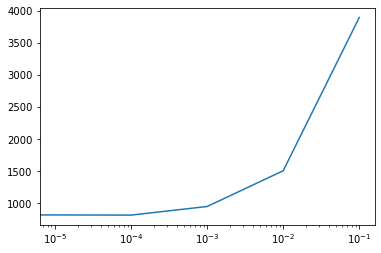

In [25]:
plt.plot(lambdas, metrics.loc['MAE',:])
plt.xscale('log')
plt.show()

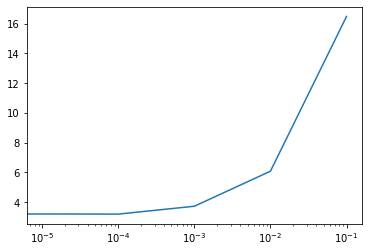

In [26]:
plt.plot(lambdas, metrics.loc['MAPE',:])
plt.xscale('log')
plt.show()

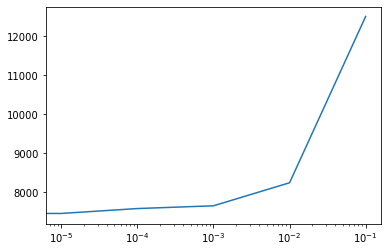

In [27]:
plt.plot(lambdas, metrics.loc['MAX',:])
plt.xscale('log')
plt.show()

## Feature selection for 

In [84]:
lambda_fit = lambdas [np.argsort(metrics.loc['MAPE',:].values)[0]]
lambda_fit

0.0001

In [85]:
lags_fit = [24*(i+1) for i in range (ndays_base) if relevances[lambda_fit][i] > 0]
exog_fit = [combined_base.columns [1+i-28] for i in range (28, len(relevances[lambda_fit])) if relevances[lambda_fit][i] > 0]

lags_fit + exog_fit

[24,
 72,
 120,
 144,
 168,
 192,
 216,
 240,
 264,
 336,
 360,
 408,
 456,
 480,
 504,
 528,
 552,
 600,
 624,
 672,
 'Day',
 'Month',
 'Week',
 'L',
 'M',
 'X',
 'J',
 'V',
 'S',
 'Temp_Cont',
 'Rad_Arido']

In [27]:
combined_base = combined_base.loc[24*ndays_base:, :]
combined_base = combined_base.reset_index(drop=True)

exog_train = combined_base[combined_base['Datetime'].dt.year - start_year < años_train]
exog_val = combined_base[(combined_base['Datetime'].dt.year - start_year - años_train < años_validation) & (combined_base['Datetime'].dt.year - start_year - años_train >= 0) ]
exog_test = combined_base[(combined_base['Datetime'].dt.year - start_year - años_train - años_validation < años_test) & (combined_base['Datetime'].dt.year - start_year - años_train - años_validation >= 0)]

exog_train = exog_train[exog_fit]
exog_val = exog_val[exog_fit]
exog_test = exog_test[exog_fit]

# Concatenate exog_train and exog_val into a single DataFrame
exog_train_val = pd.concat([exog_train, exog_val]).reset_index(drop=True)

exog_train_val_test = pd.concat([exog_train_val, exog_test]).reset_index(drop=True)

exog_val = exog_val.reset_index(drop=True)
exog_test = exog_test.reset_index(drop=True)

In [28]:
exog_train_val

,Day,Month,Week,L,M,X,J,V,S,Temp_Cont,Rad_Arido
0,1,3,9,0.0,0.0,0.0,0.0,0.0,0.909835,0.520690,0.578421
1,1,3,9,0.0,0.0,0.0,0.0,0.0,0.909835,0.527520,0.578421
2,1,3,9,0.0,0.0,0.0,0.0,0.0,0.909835,0.533710,0.578421
3,1,3,9,0.0,0.0,0.0,0.0,0.0,0.909835,0.535708,0.578421
4,1,3,9,0.0,0.0,0.0,0.0,0.0,0.909835,0.538196,0.578421
...,...,...,...,...,...,...,...,...,...,...,...
77467,31,12,52,0.0,0.0,0.0,0.0,0.0,0.546144,0.619653,0.578421
77468,31,12,52,0.0,0.0,0.0,0.0,0.0,0.546144,0.614703,0.578421
77469,31,12,52,0.0,0.0,0.0,0.0,0.0,0.546144,0.607569,0.578421
77470,31,12,52,0.0,0.0,0.0,0.0,0.0,0.546144,0.606012,0.578421


## Fine tuning of the model

In [29]:
def predict (forecaster, y_, start, npreds, flag_exog, exog, lags=lags_fit,steps = 24):
    cont = 0
    preds_list = []
    start_window = start-max(lags)
    end_window = start
    while cont < npreds:
        window = pd.Series(y_[start_window:end_window])

        if flag_exog:
            window_exog = exog.loc[cont:cont+steps]
            window_exog = window_exog.reset_index(drop=True, inplace=False)
            window_exog.index = window_exog.index + len(window)
    #         print (window_exog)
            preds = forecaster.predict(steps=steps,last_window=window,exog=window_exog)

        else:
            preds = forecaster.predict(steps=steps,last_window=window)

        preds_list.append(list(preds))

        cont += steps
        start_window += steps
        end_window += steps

    predictions = [item for sublist in preds_list for item in sublist]
    
    return predictions

def shap_information (forecaster, y_, flag_exog, exog):
    if flag_exog:
        a, _ = forecaster.create_train_X_y(
            y=pd.Series(y_), 
            exog=exog)
    else:
        a, _ = forecaster.create_train_X_y(
            y=pd.Series(y_))
        
    explainer = shap.TreeExplainer(forecaster.regressor)
    shap_values = explainer.shap_values(a)
    shap.summary_plot(shap_values, a, plot_type="bar")
    shap.summary_plot(shap_values, a)
    return shap_values

In [30]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

# Crear el forecaster
# ==============================================================================
forecaster_opt = ForecasterAutoreg(
                 regressor = XGBRegressor(),
                 lags = lags_fit,
            )
             
# Entrena el forecaster
# ==============================================================================
forecaster_opt.fit(y=pd.Series(y_train+y_val), 
               exog = exog_train_val)
# forecaster

In [31]:
from skforecast.model_selection import bayesian_search_forecaster

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 300, 1500, step=20),
        'max_depth'     : trial.suggest_int('max_depth', 3, 15, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.0001, 0.5, log=True),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0.001, 1, log=True),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0.001, 1, log=True),
        'subsample'    : trial.suggest_float('subsample', 0, 1),
    } 
    return search_space

resultados_busqueda, frozen_trial = bayesian_search_forecaster(
                                        forecaster         = forecaster_opt,
                                        y                  = pd.Series(y_train+y_val),
                                        exog               = exog_train_val,
                                        steps              = 1,
                                        metric             = 'mean_squared_error',
                                        search_space       = search_space,
                                        initial_train_size = len(y_train),
                                        refit              = False,
                                        n_trials           = 100, # Aumentar para una búsqueda más exhaustiva
#                                         random_state       = 123,
                                        return_best        = True,
                                        n_jobs             = 'auto',
                                        verbose            = False,
                                        show_progress      = True
                                    )

resultados_busqueda

  0%|          | 0/100 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 24  72 120 144 168 192 216 240 264 336 360 408 456 480 504 528 552 600
 624 672] 
  Parameters: {'n_estimators': 1120, 'max_depth': 6, 'learning_rate': 0.046056961006692994, 'reg_alpha': 0.33853215701415756, 'reg_lambda': 0.0075799012055038535, 'subsample': 0.6709519422345626}
  Backtesting metric: 0.0015526204647688046



,lags,params,mean_squared_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda,subsample
90,"[24, 72, 120, 144, 168, 192, 216, 240, 264, 33...","{'n_estimators': 1120, 'max_depth': 6, 'learni...",0.001553,1120.0,6.0,0.046057,0.338532,0.007580,0.670952
34,"[24, 72, 120, 144, 168, 192, 216, 240, 264, 33...","{'n_estimators': 1100, 'max_depth': 6, 'learni...",0.001563,1100.0,6.0,0.064682,0.531834,0.008064,0.571851
74,"[24, 72, 120, 144, 168, 192, 216, 240, 264, 33...","{'n_estimators': 1140, 'max_depth': 6, 'learni...",0.001574,1140.0,6.0,0.056748,0.440742,0.058351,0.478159
65,"[24, 72, 120, 144, 168, 192, 216, 240, 264, 33...","{'n_estimators': 1040, 'max_depth': 6, 'learni...",0.001582,1040.0,6.0,0.130818,0.256759,0.086546,0.737637
92,"[24, 72, 120, 144, 168, 192, 216, 240, 264, 33...","{'n_estimators': 1140, 'max_depth': 6, 'learni...",0.001583,1140.0,6.0,0.048974,0.359285,0.008356,0.662412
...,...,...,...,...,...,...,...,...,...
0,"[24, 72, 120, 144, 168, 192, 216, 240, 264, 33...","{'n_estimators': 1140, 'max_depth': 6, 'learni...",0.014639,1140.0,6.0,0.000690,0.045076,0.144015,0.423106
82,"[24, 72, 120, 144, 168, 192, 216, 240, 264, 33...","{'n_estimators': 1060, 'max_depth': 6, 'learni...",0.027003,1060.0,6.0,0.000360,0.334652,0.032601,0.483783
8,"[24, 72, 120, 144, 168, 192, 216, 240, 264, 33...","{'n_estimators': 920, 'max_depth': 10, 'learni...",0.032586,920.0,10.0,0.000279,0.301316,0.064444,0.545068
20,"[24, 72, 120, 144, 168, 192, 216, 240, 264, 33...","{'n_estimators': 1220, 'max_depth': 7, 'learni...",0.040039,1220.0,7.0,0.000117,0.319963,0.096877,0.741141


In [32]:
opt_predictions = predict (forecaster_opt, y, len(y_train+y_val), len(y_test), True, exog_test)

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common 

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common 

C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common 

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common 

C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  retur

C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common 

C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
C:\Users\david\.anaconda\lib\site-packages\pandas\core\dtypes\cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
C:\Users\david\.anaconda\lib\site-packages\pandas\core\algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common 

In [33]:
df_opt, opt_metrics = metricas(opt_predictions, y_test, True)
opt_metrics

[898.0607689172894, 635.3170661929229, 2.4619270737265384, 5546.968349328192]

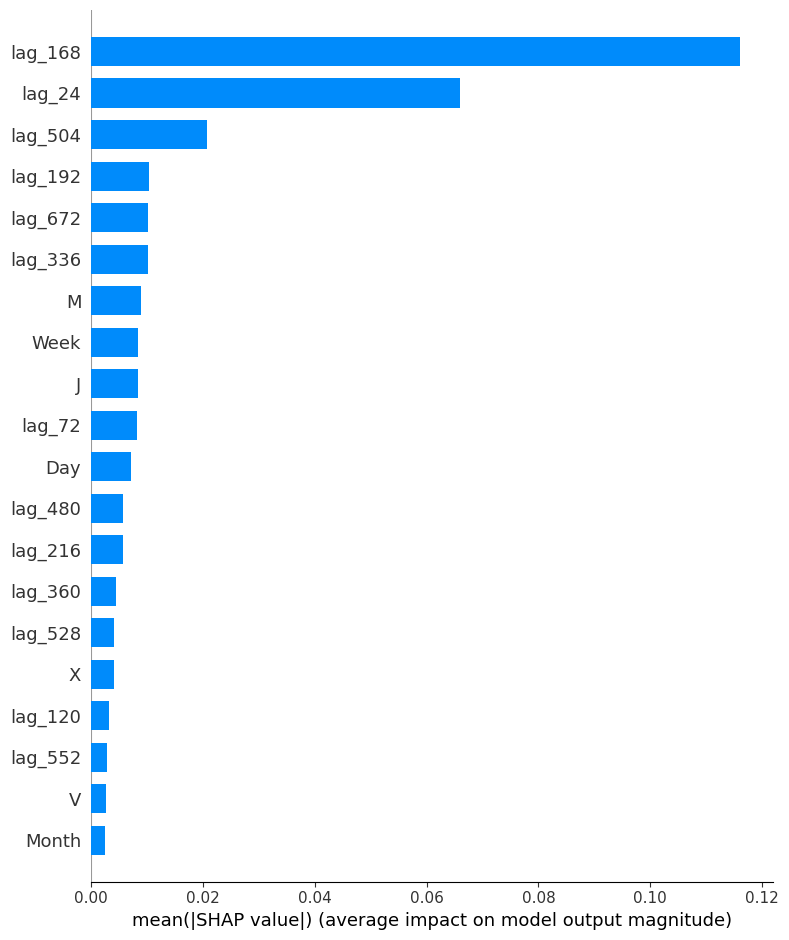

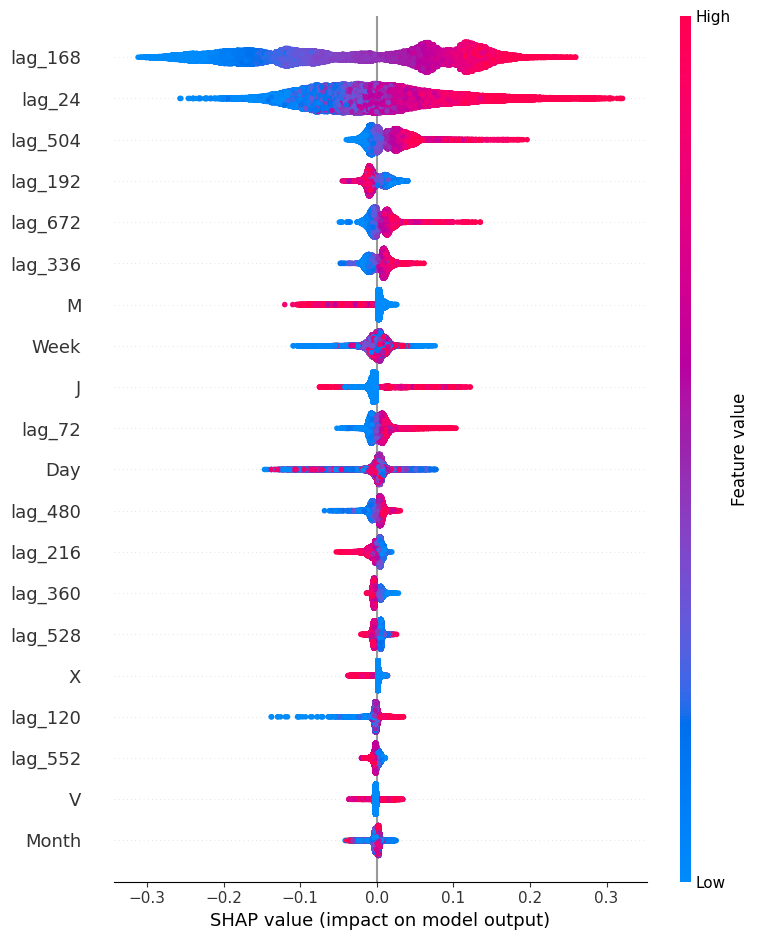

array([[-4.8001420e-02, -2.8674069e-03, -1.4646600e-03, ...,
        -3.6338139e-03,  8.8959187e-04,  9.6000283e-04],
       [-4.0651146e-02, -6.4142230e-03, -1.8057848e-03, ...,
        -3.2433851e-03,  3.8770540e-04,  7.7639328e-04],
       [-7.3989123e-02, -8.2927728e-03, -2.3506081e-03, ...,
        -2.5442140e-03,  7.3688873e-04,  8.6345157e-04],
       ...,
       [ 7.3372193e-02,  1.7748199e-03, -8.4155885e-04, ...,
        -1.5108690e-04, -4.6369250e-04,  1.1692301e-03],
       [ 2.1061514e-02, -2.1535822e-03, -1.1145963e-03, ...,
        -5.6033809e-04, -2.8628297e-04,  7.2548597e-04],
       [-1.5915895e-03, -5.2837878e-03, -1.4881706e-03, ...,
        -8.8546454e-05,  1.5622845e-08,  6.4575911e-04]], dtype=float32)

In [34]:
shap_information (forecaster_opt, y_train+y_val, True, exog_train_val)